##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFRecords と tf.train.Example

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/tfrecord"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/load_data/tfrecord.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/load_data/tfrecord.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/load_data/tfrecord.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

TFRecord 形式は一連のバイナリレコードを格納するための単純な形式です。

[プロトコルバッファ](https://developers.google.com/protocol-buffers/)は、構造化データを効率的にシリアル化するクロスプラットフォームのクロス言語ライブラリです。

プロトコルメッセージは `.proto` ファイルによって定義されており、通常、メッセージの型を最も簡単に理解する方法です。

`tf.train.Example` メッセージ（または protobuf）は柔軟なメッセージ型で、`{"string": value}` マッピングを表現します。TensorFlow と使用するように設計されており、[TFX](https://www.tensorflow.org/tfx/) などのより高位な API で使用されます。

このノートブックは、`tf.train.Example` メッセージを作成、解析、および使用してから、`.tfrecord` へ、または `.tfrecord` から `tf.train.Example` メッセージをシリアル化、書き込み、および読み取る方法を示しています。

注意: これらの構造は便利ですが、オプションです。 [tf.data を使用していて](https://www.tensorflow.org/guide/data)、データの読み取りがトレーニングのボトルネックでない限り、TFRecords を使用するために既存のコードを変換する必要はありません。データセットのパフォーマンスに関するヒントについては、[tf.data API](https://www.tensorflow.org/guide/data_performance) によるパフォーマンスの向上を参照してください。

注意: 一般に、I/O を（単一のホスト内または複数のホスト間で） 並列化できるように、データを複数のファイルに分割する必要があります。経験則では、データを読み取るホストの少なくとも 10 倍のファイルを用意します。同時に、I/O プリフェッチのメリットを享受できるように、各ファイルは十分な大きさ（少なくとも 10 MB 以上、理想的には 100 MB 以上）である必要があります。たとえば、`X` GB のデータがあり、最大`N` ホストでトレーニングすることを計画しているとします。理想的には、 ~`X/(10*N)` が10MB 以上（理想的には100 MB 以上）である限り、データを ~`10*N` ファイルにシャーディングする必要があります。それより少ない場合は、並列処理の利点と I/O プリフェッチの利点をトレードオフするために、作成するシャードの数を減らす必要がある場合があります。

## セットアップ

In [2]:
import tensorflow as tf

import numpy as np
import IPython.display as display

2024-01-11 17:51:27.052018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 17:51:27.052065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 17:51:27.053670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## `tf.train.Example`

### `tf.train.Example` のデータ型

基本的に、`tf.train.Example` は `{"string": tf.train.Feature}` というマッピングです。

`tf.train.Feature` メッセージ型は次の 3 つの型のうち 1 つを取ることができます（[`.proto` ファイル](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto)を参照）。ほとんどのその他の汎用的なデータ型は、強制的に次のいずれかにすることができます。

1. `tf.train.BytesList`（次の型を強制できます）

- `string`
- `byte`

1. `tf.train.FloatList`（次の型を強制できます）

- `float`(`float32`)
- `double`(`float64`)

1. `tf.train.Int64List`（次の型を強制できます）

- `bool`
- `enum`
- `int32`
- `uint32`
- `int64`
- `uint64`

標準の TensorFlow 型を `tf.train.Example` 互換の `tf.train.Feature` に変換するには、以下のショートカット関数を使用できます。各関数はスカラー入力値を受け取り、上記の 3 つの `list` 型のいずれかを含む `tf.train.Feature` を返すことに注意してください。

In [3]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

注意: 簡単にするために、この例ではスカラー入力のみを使用しています。非スカラー特徴量を処理する最も簡単な方法は、`tf.io.serialize_tensor` を使用してテンソルをバイナリ文字列に変換することです。文字列は TensorFlow ではスカラーです。`tf.io.parse_tensor` を使用して、バイナリ文字列をテンソルに変換し直します。

以下は、これらの関数がどのように機能するかの例です。さまざまな入力型と標準化された出力型に注意してください。関数の入力型が上記の強制可能な型のいずれかと一致しない場合、関数は例外を発生します（`1.0` は浮上小数点数なので、`_int64_feature(1.0)` はエラーを発生します。この場合は、`_float_feature` を代わりに使用する必要があります）。

In [4]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



proto メッセージはすべて `.SerializeToString` メソッドを使ってバイナリ文字列にシリアル化できます。

In [5]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

### `tf.train.Example` メッセージを作成する

既存のデータから `tf.train.Example` を作成するとします。実際には、データセットの出処はどこでもよいのですが、1 件の観測記録から `tf.train.Example` メッセージを作成する手順は変わりません。

1. 各観測記録において、上記のいずれかの関数を使用して、それぞれの値を 3 つの互換性のある型のいずれかを含む `tf.train.Feature` に変換する必要があります。

2. 特徴量名の文字列から、手順 1 で生成されたエンコード済みの特徴量の値にマップ（ディクショナリ）を作成します。

3. 手順 2 で生成されたマップを [`Features` メッセージ](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto#L85)に変換します。

このノートブックでは、NumPy を使ってデータセットを作成します。

このデータセットには次の 4 つの特徴量があります。

- `False` または `True` を表す同等の発生確率を持つブール型の特徴量。
- `[0, 5]` から一様にランダムに選択される整数の特徴量。
- 整数の特徴量をインデックスとして使用することによって文字列のテーブルから生成される文字列の特徴量。
- 標準正規分布の浮動小数点数の特徴量。

サンプルは上記の分布から独立して同じ様に分布した 10,000 件の観測記録からなるものとします。

In [6]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature.
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution.
feature3 = np.random.randn(n_observations)

これらの特徴量は、`_bytes_feature`、`_float_feature`、`_int64_feature` のいずれかを使って `tf.train.Example` と互換性のある型に強制されます。その後で、エンコード済みの特徴量から `tf.train.Example` メッセージを作成できます。

In [7]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

たとえば、データセットに `[False, 4, bytes('goat'), 0.9876]` という 1 つの観測記録があるとします。`create_message()` を使うとこの観測記録から `tf.train.Example` メッセージを作成して出力できます。それぞれの観測記録は上記に従って `Features` メッセージとして書き込まれます。`tf.train.Example` [メッセージ](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto#L88)は、この `Features` メッセージを囲むラッパーに過ぎないことに注意してください。

In [8]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat'

メッセージをデコードするには、`tf.train.Example.FromString` メソッドを使用します。

In [9]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

## TFRecords 形式の詳細

TFRecord ファイルには、一連のレコードが含まれています。ファイルは順番にのみ読み取ることができます。

各レコードには、データペイロード用のバイト文字列とデータ長と整合性チェックのための CRC-32C （[Castagnol多項式](https://en.wikipedia.org/wiki/Cyclic_redundancy_check#Standards_and_common_use)を使用した [32 ビット CRC](https://en.wikipedia.org/wiki/Cyclic_redundancy_check#CRC-32_algorithm)）ハッシュが含まれています。

各レコードは次の形式で保存されます。

```
uint64 length
uint32 masked_crc32_of_length
byte   data[length]
uint32 masked_crc32_of_data
```

レコードは連結されてファイルが生成されます。CRC の詳細は[こちらを参照してください](https://en.wikipedia.org/wiki/Cyclic_redundancy_check)。CRC のマスクは次のとおりです。

```
masked_crc = ((crc >> 15) | (crc << 17)) + 0xa282ead8ul
```


注意: TFRecord ファイルで`tf.train.Example` を使う必要はありません。`tf.train.Example` はディクショナリをバイト文字列にシリアル化する方法にすぎません。TensorFlow でデコードできるバイト文字列は、TFRecord ファイルに保存できます。例としては、テキスト行、JSON（`tf.io.decode_json_example` を使用）、エンコードされた画像データ、シリアル化された `tf.Tensors`（`tf.io.serialize_tensor`/`tf.io.parse_tensor` を使用）などがあります。その他のオプションについては、<code>tf.io</code> モジュールを参照してください。

## `tf.data` を使った TFRecord ファイル

`tf.data` モジュールには、TensorFlow でデータを読み書きするツールも含まれています。

### TFRecord ファイルを書き込む

データをデータセットに書き込む最も簡単な方法は `from_tensor_slices` メソッドを使用する方法です。

配列に適用すると、このメソッドはスカラー値のデータセットを返します。

In [10]:
tf.data.Dataset.from_tensor_slices(feature1)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

配列のタプルに適用すると、タプルのデータセットを返します。

In [11]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.bool, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [12]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'dog', shape=(), dtype=string)
tf.Tensor(0.23695644491000212, shape=(), dtype=float64)


`Dataset` のそれぞれの要素に関数を適用するには、`tf.data.Dataset.map` メソッドを使用します。

マップされる関数は TensorFlow のグラフモードで動作する必要があり、`tf.Tensors` を処理して返す必要があります。`serialize_example` のような非テンソル関数は、互換性を得るために `tf.py_function` で囲むことができます。

`tf.py_function` を使用する際は、形状と型を指定する必要があります。指定しない場合、形状と型を利用できません。

In [13]:
def tf_serialize_example(f0,f1,f2,f3):
  tf_string = tf.py_function(
    serialize_example,
    (f0, f1, f2, f3),  # Pass these args to the above function.
    tf.string)      # The return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar.

In [14]:
tf_serialize_example(f0, f1, f2, f3)

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xb6\xa4r>'>

この関数をデータセットのそれぞれの要素に適用します。

In [15]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [16]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

In [17]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [18]:
serialized_features_dataset

<_FlatMapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

TFRecord ファイルに書き込みます。

In [19]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


### TFRecord ファイルを読み取る

`tf.data.TFRecordDataset` クラスを使って TFRecord ファイルを読み取ることもできます。

`tf.data` を使用した TFRecord ファイルの使用の詳細については、[tf.data: Build TensorFlow 入力パイプライン](https://www.tensorflow.org/guide/data#consuming_tfrecord_data)ガイドを参照してください。

`TFRecordDataset` を使うと、入力データを標準化し、パフォーマンスを最適化するのに役立ちます。

In [20]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

この時点で、データセットにはシリアル化された `tf.train.Example` メッセージが含まれています。データセットをイテレートすると、これらのメッセージはスカラーの文字列テンソルとして返されます。

`.take` メソッドを使って最初の 10 件のレコードのみを表示します。

注意: `tf.data.Dataset` をイテレートできるのは、Eager execution が有効になっている場合のみです。

In [21]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xb6\xa4r>'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x89\xb6\x85\xbf\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x11\xc1_?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x9ca\xc3>\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\

これらのテンソルは、以下の関数を使用して解析できます。`tf.data.Dataset` は graph-execution を使用するため、ここでは `feature_description` が必要であり、形状と型のシグネチャを作成するには次の説明が必要です。

In [22]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

または、`tf.parse_example` を使用して、すべてのバッチをまとめて解析します。`tf.data.Dataset.map` メソッドを使用して、データセットの各項目にこの関数を適用します。

In [23]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<_MapDataset element_spec={'feature0': TensorSpec(shape=(), dtype=tf.int64, name=None), 'feature1': TensorSpec(shape=(), dtype=tf.int64, name=None), 'feature2': TensorSpec(shape=(), dtype=tf.string, name=None), 'feature3': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

Eager Execution を使ってデータセット中の観測記録を表示します。このデータセットには 10,000 件の観測記録がありますが、最初の 10 個だけ表示します。 データは特徴量のディクショナリの形で表示されます。それぞれの項目は `tf.Tensor` であり、このテンソルの `numpy` 要素は特徴量を表します。

In [24]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.23695645>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'goat'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-1.044633>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.8740397>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.38160408>}
{'feature0': <tf.

ここでは、`tf.parse_example` 関数が `tf.train.Example` のフィールドを標準的なテンソルに展開しています。

## Python の TFRecord ファイル

`tf.io` モジュールには、TFRecord ファイルを読み書きするための純粋な Python 関数も含まれています。

### TFRecord ファイルを書き込む

次にこの 10,000 件の観測記録を `test.tfrecords` ファイルに書き込みます。それぞれの観測記録は `tf.train.Example` メッセージに変換されてからファイルに書き込まれます。その後、`test.tfrecord` ファイルが作成されたことを確認します。

In [25]:
# Write the `tf.train.Example` observations to the file.
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    writer.write(example)

/tmpfs/tmp/ipykernel_17528/1733628823.py:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [26]:
!du -sh {filename}

984K	test.tfrecord


### TFRecord ファイルを読み取る

これらのシリアル化されたテンソルは、`tf.train.Example.ParseFromString` を使用して簡単に解析できます。

In [27]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [28]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "dog"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.23695644736289978
      }
    }
  }
}



これは、そのままでは使いにくい `tf.train.Example` プロトを返しますが、基本的には表現は次の通りです。

```
Dict[str,
     Union[List[float],
           List[int],
           List[str]]]
```

次のコードは、TensorFlow 演算を使用せずに、`Example` を NumPy 配列のディクショナリに手動で変換します。詳細については、[PROTO ファイル](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto)をご覧ください。

In [29]:
result = {}
# example.features.feature is the dictionary
for key, feature in example.features.feature.items():
  # The values are the Feature objects which contain a `kind` which contains:
  # one of three fields: bytes_list, float_list, int64_list

  kind = feature.WhichOneof('kind')
  result[key] = np.array(getattr(feature, kind).value)

result

{'feature3': array([0.23695645]),
 'feature2': array([b'dog'], dtype='|S3'),
 'feature1': array([1]),
 'feature0': array([0])}

## ウォークスルー: 画像データの読み書き

これは、TFRecord を使って画像データを読み書きする方法を示すエンドツーエンドの例です。画像を入力データとして使用し、そのデータを TFRecord ファイルとして書き込んでから、ファイルを読み取り直して画像を表示します。

これは、同じ入力データセットに複数のモデルを使用する場合などに役立ちます。画像データを未加工のまま保存する代わりに、事前に TFRecord 形式に処理しておくことが可能で、その形式を以降の処理やモデル構築に使用することができます。

まずは、雪の中の猫の[画像](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg)と、ニューヨーク市にある建設中のウイリアムズバーグ橋の[写真](https://upload.wikimedia.org/wikipedia/commons/f/fe/New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg)をダウンロードしましょう。

### 画像をフェッチする

In [30]:
cat_in_snow  = tf.keras.utils.get_file(
    '320px-Felis_catus-cat_on_snow.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')

williamsburg_bridge = tf.keras.utils.get_file(
    '194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

 8192/17858 [============>.................] - ETA: 0s

17858/17858 [==============================] - 0s 0us/step


 8192/15477 [==============>...............] - ETA: 0s

15477/15477 [==============================] - 0s 0us/step


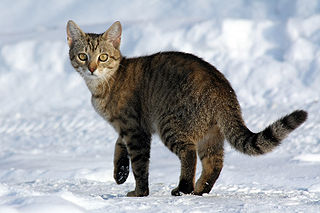

In [31]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

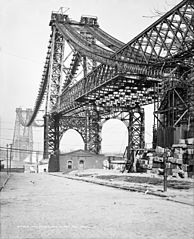

In [32]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">From Wikimedia</a>'))

### TFRecord ファイルを書き込む

前と同じように、この特徴量を `tf.train.Example` と互換性のあるデータ型にエンコードします。この場合には、生の画像文字列の特徴量だけではなく、高さ、幅、深度、および任意の `label` 特徴量も保存します。ラベルはファイルに書き込む際に猫の画像と橋の画像を区別するために使用されます。猫の画像には `0` を、橋の画像には `1` を使用します。

In [33]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [34]:
# This is an example, just using the cat image.
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.io.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


すべての特徴量が `tf.train.Example` メッセージに保存されたのがわかります。上記のコードを関数化し、このサンプルメッセージを `images.tfrecords` というファイルに書き込みます。

In [35]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [36]:
!du -sh {record_file}

36K	images.tfrecords


### TFRecord ファイルを読み取る

これで、`images.tfrecords` ファイルができました。このファイルに含まれるレコードをイテレートし、書き込んだものを読み取ります。このユースケースでは画像を復元するだけであるため、生画像の文字列だけが必要となります。上記のゲッター、すなわち、`example.features.feature['image_raw'].bytes_list.value[0]` を使って抽出することができます。また、猫と橋のどちらであるかを判定するためにラベルを使用できます。

In [37]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<_MapDataset element_spec={'depth': TensorSpec(shape=(), dtype=tf.int64, name=None), 'height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image_raw': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

TFRecord ファイルから画像を復元します。

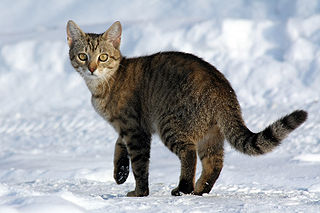

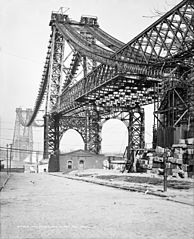

In [38]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))